In [1]:
!pip install pyupbit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 7.6 MB/s 


In [2]:
import pyupbit
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import matplotlib.pyplot as plt
import random

In [3]:
seed_num = 0
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

In [4]:
def windowed_dataset(x, y, window_size, batch_size, shuffle):
    # X값 window dataset 구성
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))
    # y값 추가
    ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [5]:
df = pyupbit.get_ohlcv("KRW-BTC", interval='minute60', count=50000)

In [6]:
df.isna().sum()

open      0
high      0
low       0
close     0
volume    0
value     0
dtype: int64

In [7]:
df

,open,high,low,close,volume,value
2017-09-25 12:00:00,4201000.0,4244000.0,4191000.0,4202000.0,98.210406,4.142651e+08
2017-09-25 13:00:00,4222000.0,4235000.0,4208000.0,4235000.0,7.656490,3.230358e+07
2017-09-25 17:00:00,4235000.0,4235000.0,4235000.0,4235000.0,0.000030,1.270500e+02
2017-09-25 19:00:00,4213000.0,4213000.0,4187000.0,4204000.0,0.914286,3.832582e+06
2017-09-25 20:00:00,4204000.0,4204000.0,4175000.0,4191000.0,2.197385,9.211909e+06
...,...,...,...,...,...,...
2022-09-30 13:00:00,27858000.0,27919000.0,27829000.0,27870000.0,152.924262,4.264450e+09
2022-09-30 14:00:00,27870000.0,27999000.0,27864000.0,27910000.0,193.208503,5.398631e+09
2022-09-30 15:00:00,27910000.0,27990000.0,27861000.0,27899000.0,164.820830,4.601214e+09
2022-09-30 16:00:00,27918000.0,28070000.0,27902000.0,27986000.0,253.506642,7.100943e+09


In [8]:
df0 = df.copy()
df_a = df.copy()

In [9]:
df0['gap'] = df0['close'] - df0['close'].shift(1)
df0['upgap'] = np.where(df0['gap']>=0, df0['gap'], 0)
df0['downgap'] = np.where(df0['gap'] <0, df0['gap'].abs(), 0)


df0['AU'] = df0['upgap'].ewm(alpha=1/12, min_periods=12).mean()
df0['AD'] = df0['downgap'].ewm(alpha=1/12, min_periods=12).mean()

df0['RSI'] = df0['AU'] / (df0['AU'] + df0['AD']) * 100


df0['ma12'] = df0['close'].rolling(window=12).mean() # 10분 이평
df0['stddev'] = df0['close'].rolling(window=12).std() # 10분 이평편차
df0['upper'] = df0['ma12'] + 2*df0['stddev'] # 상단밴드
df0['lower'] = df0['ma12'] - 2*df0['stddev'] # 하단밴드
df0['bandwidth'] = df0['upper'] - df0['lower']


df0['disparity'] = 100*(df0['close']/df0['ma12'])


df0.drop(['AU','AD','upgap','downgap','upper','lower','gap','ma12','stddev'], axis = 1, inplace = True)

In [10]:
df1 = df0.iloc[20:,:]

df1_columns = ['open', 'high', 'low', 'close', 'volume', 'value', 'RSI', 'bandwidth',
       'disparity']

df_b = df_a.iloc[20:,:]

df_b_columns = ['open', 'high', 'low', 'close', 'volume', 'value']

In [11]:
df1

,open,high,low,close,volume,value,RSI,bandwidth,disparity
2017-09-26 12:00:00,4380000.0,4380000.0,4330000.0,4333000.0,1.160199,5.049426e+06,62.224602,82596.500036,100.202347
2017-09-26 13:00:00,4333000.0,4351000.0,4321000.0,4346000.0,0.692955,3.002899e+06,64.844663,82264.908385,100.423631
2017-09-26 14:00:00,4346000.0,4352000.0,4311000.0,4324000.0,0.829987,3.591885e+06,57.483995,76966.738192,99.876809
2017-09-26 15:00:00,4318000.0,4349000.0,4318000.0,4345000.0,0.429371,1.858044e+06,61.978274,75952.138039,100.300092
2017-09-26 16:00:00,4345000.0,4369000.0,4333000.0,4367000.0,0.284767,1.238569e+06,66.076536,84103.111318,100.716880
...,...,...,...,...,...,...,...,...,...
2022-09-30 13:00:00,27858000.0,27919000.0,27829000.0,27870000.0,152.924262,4.264450e+09,49.592767,380840.537148,100.008373
2022-09-30 14:00:00,27870000.0,27999000.0,27864000.0,27910000.0,193.208503,5.398631e+09,51.344324,324990.628595,100.091449
2022-09-30 15:00:00,27910000.0,27990000.0,27861000.0,27899000.0,164.820830,4.601214e+09,50.814610,289362.935904,100.012547
2022-09-30 16:00:00,27918000.0,28070000.0,27902000.0,27986000.0,253.506642,7.100943e+09,54.834981,307084.036779,100.294464


In [12]:
scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(df1[df1_columns])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df1_columns

df_b_scaled = scaler.fit_transform(df_b[df_b_columns])
df_b_scaled = pd.DataFrame(df_b_scaled)
df_b_scaled.columns = df_b_columns

In [13]:
train_weight = 0.8
split = int(len(df) * train_weight)

df_train = df_scaled.iloc[:split]
df_test = df_scaled.iloc[split:]

df_non_train = df_b_scaled.iloc[:split]
df_non_test = df_b_scaled.iloc[split:]

In [14]:
df_train_x = df_train.drop(['close'], axis = 1)
df_train_y = df_train['close']

df_test_x = df_test.drop(['close'], axis = 1)
df_test_y = df_test['close']

df_non_train_x = df_non_train.drop(['close'], axis = 1)
df_non_train_y = df_non_train['close']

df_non_test_x = df_non_test.drop(['close'], axis = 1)
df_non_test_y = df_non_test['close']

In [15]:
WINDOW_SIZE=5
BATCH_SIZE=64

In [16]:
train_data = windowed_dataset(df_train_x, df_train_y, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(df_test_x, df_test_y, WINDOW_SIZE, BATCH_SIZE, False)

In [17]:
train_data_non = windowed_dataset(df_non_train_x, df_non_train_y, WINDOW_SIZE, BATCH_SIZE, True)
test_data_non = windowed_dataset(df_non_test_x, df_non_test_y, WINDOW_SIZE, BATCH_SIZE, False)

In [18]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu"),
    # LSTM
    LSTM(16, activation='tanh', return_sequences=True),
    LSTM(16, activation="relu"),
    Dense(1),
])

In [19]:
model2 = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu"),
    # LSTM
    LSTM(16, activation='tanh', return_sequences=True),
    LSTM(16, activation="relu"),
    Dense(1),
])

In [20]:
loss = Huber()
model.compile(loss=Huber(), optimizer='adam', metrics=['mse'])
model2.compile(loss=Huber(), optimizer='adam', metrics=['mse'])

In [21]:
# earlystopping은 35번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=20)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [22]:
filename2 = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint2 = ModelCheckpoint(filename2, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [23]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=100, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100
    544/Unknown - 12s 14ms/step - loss: 1.0658e-04 - mse: 2.1315e-04
Epoch 1: val_loss improved from inf to 0.00004, saving model to tmp/ckeckpointer.ckpt
549/549 [==============================] - 15s 18ms/step - loss: 1.0593e-04 - mse: 2.1186e-04 - val_loss: 3.5909e-05 - val_mse: 7.1819e-05
Epoch 2/100
545/549 [============================>.] - ETA: 0s - loss: 2.2412e-05 - mse: 4.4823e-05
Epoch 2: val_loss improved from 0.00004 to 0.00003, saving model to tmp/ckeckpointer.ckpt
549/549 [==============================] - 9s 15ms/step - loss: 2.2412e-05 - mse: 4.4825e-05 - val_loss: 2.5733e-05 - val_mse: 5.1466e-05
Epoch 3/100
545/549 [============================>.] - ETA: 0s - loss: 1.3631e-05 - mse: 2.7262e-05
Epoch 3: val_loss improved from 0.00003 to 0.00002, saving model to tmp/ckeckpointer.ckpt
549/549 [==============================] - 9s 17ms/step - loss: 1.3672e-05 - mse: 2.7344e-05 - val_loss: 2.0112e-05 - val_mse: 4.0224e-05
Epoch 4/100
549/549 [=================

In [24]:
print("%.7f" % (float(min(history.history['val_loss']))))
model.load_weights(filename)
pred = model.predict(test_data)
actual = np.asarray(df_test_y)[WINDOW_SIZE:]
actual = np.reshape(actual, (len(actual), 1))
print(pred.shape)
print(actual.shape)

0.0000088
(8751, 1)
(8751, 1)


In [25]:
history2 = model2.fit(train_data_non, 
                    validation_data=(test_data_non), 
                    epochs=100, 
                    callbacks=[checkpoint2, earlystopping])

Epoch 1/100
    543/Unknown - 12s 13ms/step - loss: 6.6649e-05 - mse: 1.3330e-04
Epoch 1: val_loss improved from inf to 0.00003, saving model to tmp/ckeckpointer.ckpt
549/549 [==============================] - 14s 17ms/step - loss: 6.6362e-05 - mse: 1.3272e-04 - val_loss: 2.7898e-05 - val_mse: 5.5796e-05
Epoch 2/100
546/549 [============================>.] - ETA: 0s - loss: 1.9585e-05 - mse: 3.9169e-05
Epoch 2: val_loss did not improve from 0.00003
549/549 [==============================] - 9s 15ms/step - loss: 1.9653e-05 - mse: 3.9306e-05 - val_loss: 3.9081e-05 - val_mse: 7.8163e-05
Epoch 3/100
548/549 [============================>.] - ETA: 0s - loss: 1.4530e-05 - mse: 2.9059e-05
Epoch 3: val_loss did not improve from 0.00003
549/549 [==============================] - 9s 16ms/step - loss: 1.4562e-05 - mse: 2.9123e-05 - val_loss: 5.0497e-05 - val_mse: 1.0099e-04
Epoch 4/100
547/549 [============================>.] - ETA: 0s - loss: 1.6338e-05 - mse: 3.2676e-05
Epoch 4: val_loss did no

In [26]:
print("%.7f" % (float(min(history2.history['val_loss']))))
model2.load_weights(filename2)
pred2 = model2.predict(test_data_non)
actual = np.asarray(df_non_test_y)[WINDOW_SIZE:]
actual = np.reshape(actual, (len(actual), 1))
print(pred.shape)
print(actual.shape)

0.0000112
(8751, 1)
(8751, 1)


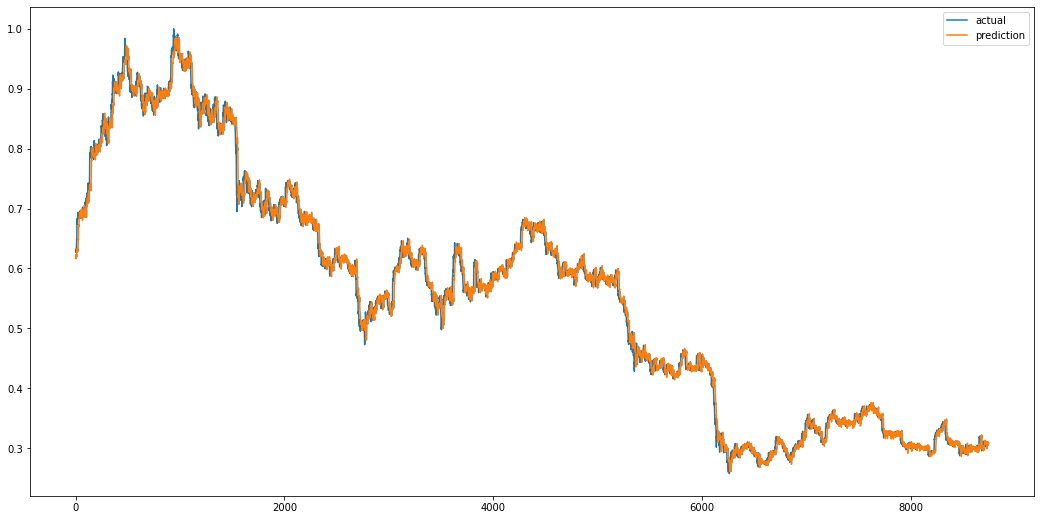

In [27]:
plt.figure(figsize=(18, 9))
plt.plot(np.asarray(df_test_y)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

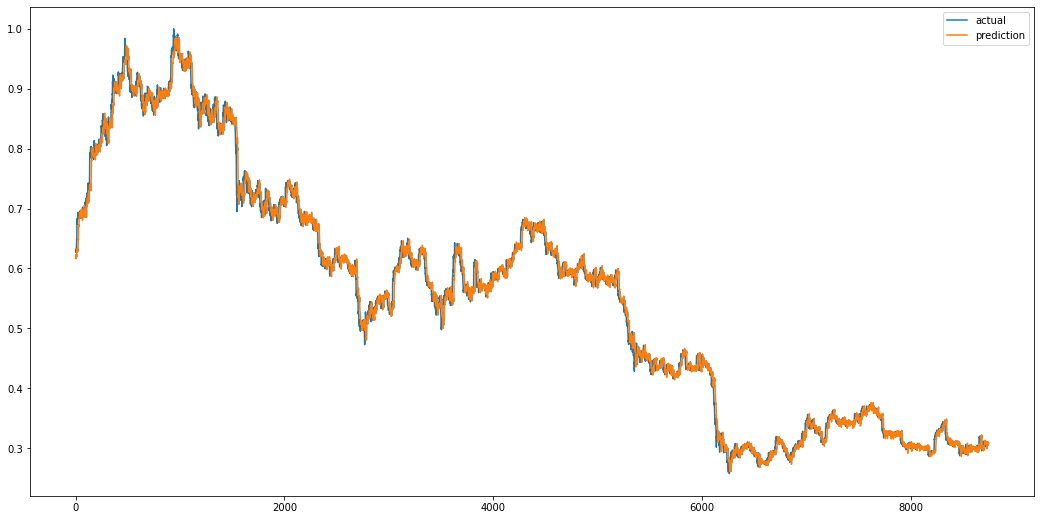

In [28]:
plt.figure(figsize=(18, 9))
plt.plot(np.asarray(df_non_test_y)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [29]:
print("%.7f" % (float(min(history2.history['val_loss']))))

0.0000112


In [30]:
print("%.7f" % (float(min(history.history['val_loss']))))

0.0000088
